<a href="https://colab.research.google.com/github/gilshm/anomaly-detection/blob/master/ee046853_01_pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technion - EE046853 - Advanced Topics in Computer Architecture
Welcome! In this exercise, we intend to give you some hands-on experience with deep neural networks (DNNs) using the PyTorch framework.
Even though this exercise is more oriented towards the software/algorithm side, the stages of develping a DNN and the techniques you'll employ here have major implications on current (and future) hardware architectures.
**bold text**
This exerecise is organized as follows:
1.   **Part I: Introduction to PyTorch** - Train a convolutional neural network (CNN) for image classification for CIFAR-100 dataset.
2.   **Part II: Quantization** - Explore quantization impact on model accuracy and hardware.
3.   **Part III: Pruning** - Explore pruning impact on model accuracy and hardware.


## Part I: Introduction to PyTorch

### CIFAR-10
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
We'll walkthrough how to code a CNN for image classification with PyTorch for the CIFAR-10 dataset. At the end, you'll do the same thing with CIFAR-100. More details can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

<center><img src="https://raw.githubusercontent.com/gilshm/ee046853/master/imgs/01_cifar10_dataset.png" alt="CIFAR-10 dataset" width="600"/></center>


### PyTorch
*For readability, this walkthrough will not detail each an every function argument; you are highly encouraged to check the PyTorch documentation by yourselves, and if something is still not clear, e-mail me.*

#### Loading CIFAR-10
PyTorch is capable of downloading CIFAR-10 (and 100) automatically. Notice that batch size is set to 128, i.e., each feed-forward consists of 128 images.
Regarding the *transforms.Normalize((...), (...))*, this is input data preprocessing (normalization) - for further details, see [here](http://cs231n.github.io/neural-networks-2/#datapre).

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Let's visualize some input images from the training set. Notice how the train loader will load different batches each time, since we initialized it with *shuffle=True*.



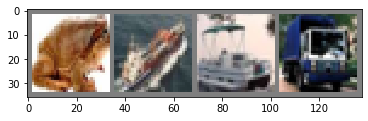

frog ship ship truck


In [0]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Get a batch from the train loader
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images[0:4, :, :, :]))
# Print their labels
print(' '.join('%s' % classes[labels[j]] for j in range(4)))

#### The CNN Model
Below an example of a simple "Light" AlexNet network - that is, 2 CONV layers followed by 3 FC layers. ReLU and max pooling is used as well.

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

#### Training
To train a neural network, we need to choose an optimizer and define a loss function.
As an optimizer, we choose the stochastic gradient descent (SGD) with a learning rate (LR) of 0.01.
The loss function we choose is cross-entropy loss which is defined as

$$
\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                       = -x[class] + \log\left(\sum_j \exp(x[j])\right),
$$

which is a composition of a log-softmax function and a negative log-likelihood loss.


In [0]:
import torch.optim as optim


LR = 0.01

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=LR)

We define a training function and a validation function.

For each batch, the training function feedforwards the inputs from the training set through the network (*model(images)*), computes the loss versus the reference or ground truth (*criterion(output, target)*), backward propogates the gradients from the loss function (*loss.backward()*), and updates the parameters (*optimizer.step()*).

The validation function uses the validation set, which the network did not explicitly trained on, to check the model accuracy.

In [0]:
import time


def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            progress.display(i)
            
            
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 100 == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

Below are additional auxiliary functions (e.g., gathering statistics).

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
      
      
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
      
      
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

It's training time! we'll try 10 epochs.

In [0]:
EPOCHS = 10

for epoch in range(0, EPOCHS):
    #adjust_learning_rate(optimizer, epoch, args)

    # train for one epoch
    train(trainloader, net, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(testloader, net, criterion)

<center><img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Barack_Obama_Mic_Drop_2016.jpg" alt="Mic drop" width="600"/></center>